# 22. Image processing

We have seen in early chapters how Numpy allows us to handle arrays of any dimensions. Images are in fact just such arrays. A gray-scale image is for example just a 2D array of pixels, an RGB image (normal JPG image for example) is a 3D image with three channels, red, green and blue. Images can also occur in many other formats, especially in sciences. For example in microscopy images can be acquired over time, as a volume and in multiple channels, thus generating up to 5D images.

Many scientific domains such geospatial sciences, biology or medicine use imaging data. Each domain has its own specificities in terms of data format and processing and therefore there are numerous specialized packages. Here we briefly introduce the generalistic image processing package ```scikit-image``` and then show an application example.

## scikit-image

scikit-image contains a series of modules that allow one to perform all steps of typical image processing analysis such as data loading, filtering, object segmentation etc. The package works mostly in a functional way following the mechanism ```image_out = func(image_in)```, making the construction of analysis pipelines relatively straightforward.

As an example of images we are using here images from the [Broad Bioimage Benckmark Collection](https://bbbc.broadinstitute.org/BBBC013). We first need to download it:

In [1]:
import requests
import zipfile
from pathlib import Path

if not Path('BBBC013_v1_images_bmp').is_dir():
    url = 'https://data.broadinstitute.org/bbbc/BBBC013/BBBC013_v1_images_bmp.zip'
    myfile = requests.get(url, allow_redirects=True)
    open('BBBC013_v1_images_bmp.zip', 'wb').write(myfile.content)
    with zipfile.ZipFile('BBBC013_v1_images_bmp.zip', 'r') as zip_ref:
        zip_ref.extractall('.')

## io

While each field has specialized packages for image import and export scikit-image offers an io module capable of handling most common formats such as tif, jpg, png etc. Images can be read directly on disk or from a url. Here we load one of the image we have just downloaded:

In [2]:
import numpy as np
import pandas as pd
import skimage
import skimage.io

In [3]:
image = skimage.io.imread('BBBC013_v1_images_bmp/Channel2-01-A-01.BMP')

In [4]:
image

array([[0, 5, 5, ..., 3, 4, 5],
       [0, 7, 7, ..., 5, 3, 4],
       [0, 5, 7, ..., 4, 3, 0],
       ...,
       [0, 5, 5, ..., 4, 5, 6],
       [0, 4, 4, ..., 6, 4, 5],
       [5, 4, 0, ..., 4, 3, 5]], dtype=uint8)

In [5]:
image.shape

(640, 640)

We see that this import returns a simple Numpy array of a gray scale image. We can plot it using the ```imshow``` function of matplotlib:

In [6]:
import matplotlib.pyplot as plt

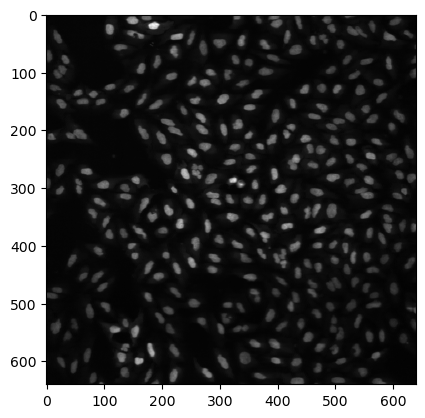

In [7]:
plt.imshow(image, cmap='gray');

We can also focus on a smaller portion of the image using array slicing to crop it:

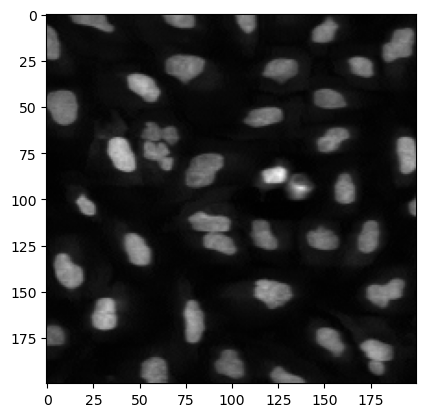

In [8]:
plt.imshow(image[200:400, 200:400], cmap='gray');

What we see above are nuclei of cells imaged by fluorescence microscopy. Our goal here will be to *segment*, i.e. find the nuclei boundaries of those nuclei to be able to analyze their properties.

## Filtering

Before we actually analyze the image, it is always a good idea to remove outliers and rough regions in the image by some filtering. For example we can use a median filter which helps suppressing pixels with extreme values. This is implemented in the ```filters``` submodule. The input here is the image, as well as an array indicating over which area we want to perform the filtering:

In [9]:
image_filtered = skimage.filters.median(image, footprint=np.ones((3,3)))

The output is still an image:

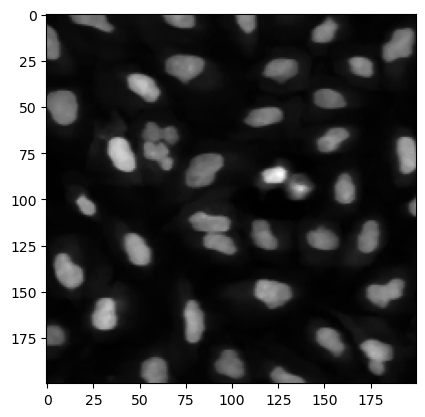

In [10]:
plt.imshow(image_filtered[200:400, 200:400], cmap='gray');

## Thresholding

Since our nuclei are bright on a dark background, we can simply apply a threshold to the image and create a binary image. Instead of picking a value manually, we can use an algorithm for that, for example the Otsu method. It is implemented in scikit-image and just takes an array as input:

In [11]:
threshold = skimage.filters.threshold_otsu(image_filtered)
threshold

46

As we have learned earlier, we can simply create a binary array with:

In [12]:
image_bw = image_filtered > threshold

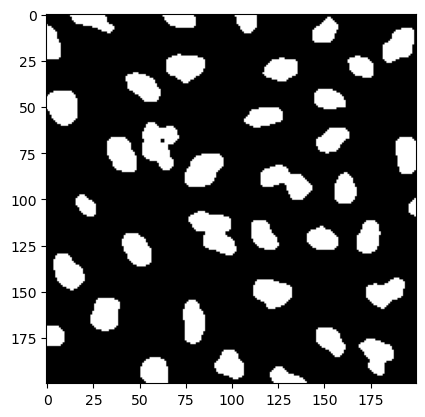

In [13]:
plt.imshow(image_bw[200:400, 200:400], cmap='gray');

## Finding objects

Now we can analyze the image and find all white pixels which are *connected* together. Like this we are able to identify each nucleus individually. Here we use the ```label``` function of the ```morphology``` module. Again both input and output are images (arrays):

In [14]:
image_label = skimage.morphology.label(image_bw)

To render the labels we use here a specialized package called ```microfilm```:

In [15]:
# on colab, please install
# pip install microfilm

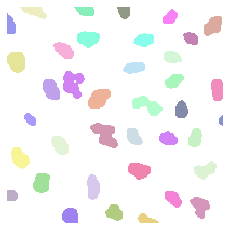

In [16]:
from microfilm import microplot

microplot.microshow(image_label[200:400, 200:400].astype(np.uint16), cmaps=['segmentation']);

## Measuring objects

Finally we can measure the properties of these objects. We can measure both geometrical and intensity based properties. For this we use the ```regionprops_table``` function and feed both the labels and intensity images. In this case we don't use the intensity of the image ```BBBC013_v1_images_bmp/Channel2-01-A-01.BMP``` but of its corresponding Channel1 image ```BBBC013_v1_images_bmp/Channel1-01-A-01.BMP```.

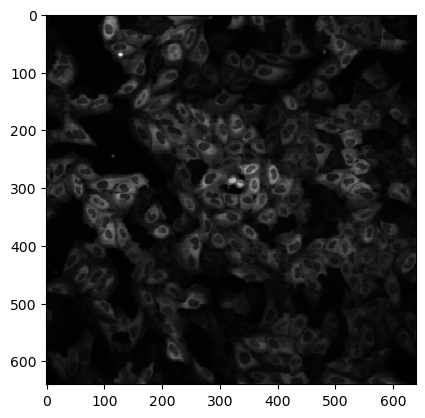

In [17]:
image2 = skimage.io.imread('BBBC013_v1_images_bmp/Channel1-01-A-01.BMP')
plt.imshow(image2, cmap='gray');

We also need to specify which properties we want to recover.

In [18]:
props = skimage.measure.regionprops_table(label_image=image_label, intensity_image=image2,
                                  properties=('label', 'area', 'eccentricity', 'mean_intensity'))

The output ```props``` is a dictionary of lists where each key corresponds to one of the above properties. We can easily turn this into a Pandas DataFrame:

In [19]:
props_df = pd.DataFrame(props)
props_df

,label,area,eccentricity,mean_intensity
0,1,21,0.987417,53.380952
1,2,114,0.628158,43.657895
2,3,121,0.878156,33.495868
3,4,393,0.645985,8.781170
4,5,21,0.776835,3.428571
...,...,...,...,...
301,302,176,0.898355,18.517045
302,303,230,0.871666,19.117391
303,304,156,0.879550,22.301282
304,305,56,0.866997,9.196429


## Creating a function

Now that we have a pipeline that works, we can turn it into a function and ideally then turn it into an installable package. Here our function takes as an input the paths to a pair of images and outputs the measured properties:

In [20]:
def my_process(image_path1, image_path2):
    
    image = skimage.io.imread(image_path1)
    image2 = skimage.io.imread(image_path2)
    image_filtered = skimage.filters.median(image, footprint=np.ones((3,3)))
    threshold = skimage.filters.threshold_otsu(image_filtered)
    image_bw = image_filtered > threshold
    image_label = skimage.morphology.label(image_bw)
    
    props = skimage.measure.regionprops_table(label_image=image_label, intensity_image=image2,
                                  properties=('label', 'area', 'eccentricity', 'mean_intensity'))
    
    props_df = pd.DataFrame(props)
    return props_df

Now we can apply our function to two pairs of images:

In [21]:
im_paths1 = ['BBBC013_v1_images_bmp/Channel2-01-A-01.BMP', 'BBBC013_v1_images_bmp/Channel2-08-A-08.BMP']
im_paths2 = ['BBBC013_v1_images_bmp/Channel1-01-A-01.BMP', 'BBBC013_v1_images_bmp/Channel1-08-A-08.BMP']

In [22]:
dfs = [my_process(p1, p2) for p1, p2 in zip(im_paths1, im_paths2)]

We obtain here a list of dataframes. We can just concatenate them:

In [23]:
df_total = pd.concat(dfs)
df_total.head(5)

,label,area,eccentricity,mean_intensity
0,1,21,0.987417,53.380952
1,2,114,0.628158,43.657895
2,3,121,0.878156,33.495868
3,4,393,0.645985,8.781170
4,5,21,0.776835,3.428571


## Analysis

Finally we can start analysing our data. For example we can make a scatter plot using seaborn of the area vs. mean_intensity:

In [24]:
import seaborn as sns

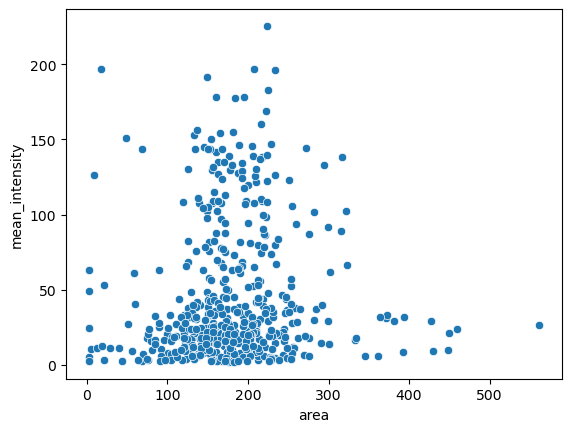

In [25]:
sns.scatterplot(data=df_total, x='area', y='mean_intensity');

And we can try to cluster our data using scikit-learn:

In [26]:
from sklearn import cluster
from sklearn import preprocessing

In [27]:
cls = cluster.AgglomerativeClustering(n_clusters=2)

cls.fit(X=preprocessing.StandardScaler().fit_transform(df_total[['area', 'mean_intensity']]))

AgglomerativeClustering()

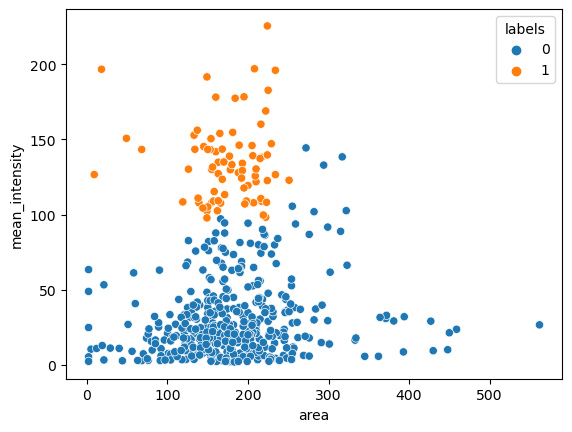

In [28]:
df_total['labels'] = pd.Categorical(cls.labels_)

sns.scatterplot(data=df_total, x='area', y='mean_intensity', hue='labels');